In [2]:
# Stock Price Prediction with GRU
# This notebook trains a GRU-based model for stock price prediction (example: Google/GOOG).

In [3]:
# Install required packages (if running in Colab)
!pip install yfinance scikit-learn keras tensorflow matplotlib pandas --quiet

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import GRU, Dense
from datetime import date

In [5]:
## 1. Download Stock Data
stock_symbol = 'GOOG'
start_date = '2020-01-01'
end_date = '2025-7-14'
data = yf.download(stock_symbol, start=start_date, end=end_date)
data = data[['Close']]

/tmp/ipython-input-5-1066686415.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [6]:
data.head()

Price,Close
Ticker,GOOG
Date,
2020-01-02,67.964508
2020-01-03,67.630989
2020-01-06,69.298576
2020-01-07,69.255341
2020-01-08,69.801094


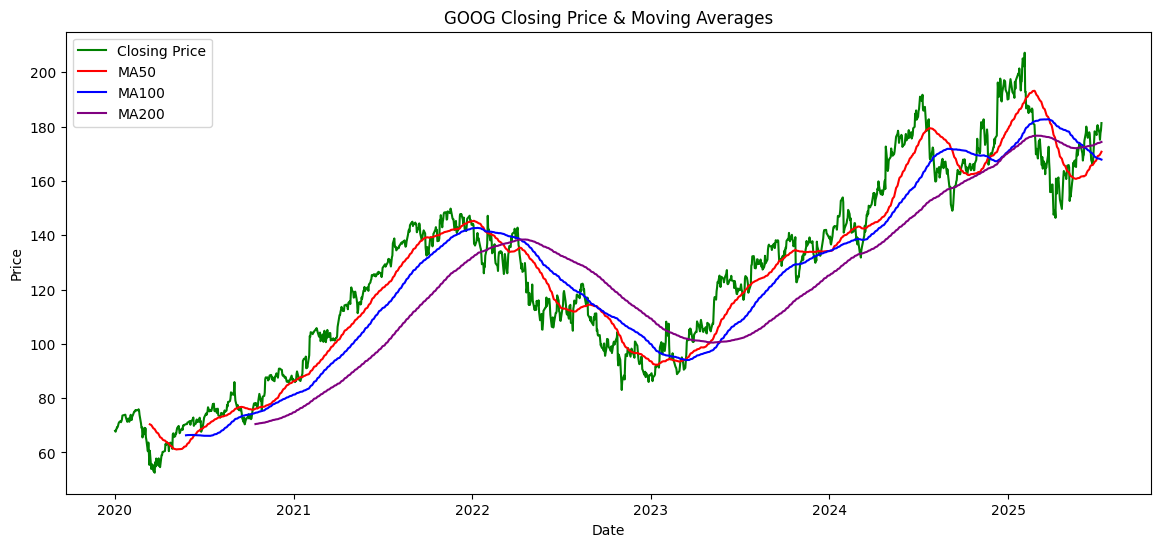

In [7]:
ma_50 = data['Close'].rolling(window=50).mean()
ma_100 = data['Close'].rolling(window=100).mean()
ma_200 = data['Close'].rolling(window=200).mean()

plt.figure(figsize=(14,6))
plt.plot(data['Close'], label='Closing Price', color='g')
plt.plot(ma_50, label='MA50', color='r')
plt.plot(ma_100, label='MA100', color='b')
plt.plot(ma_200, label='MA200', color='purple')
plt.title(f'{stock_symbol} Closing Price & Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [8]:
## 2. Preprocess Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[:training_data_len]
test_data = scaled_data[training_data_len - 100:]

In [9]:
# Create sequences
def create_sequences(dataset, window_size=100):
    x, y = [], []
    for i in range(window_size, len(dataset)):
        x.append(dataset[i-window_size:i, 0])
        y.append(dataset[i, 0])
    return np.array(x), np.array(y)

x_train, y_train = create_sequences(train_data)
x_test, y_test = create_sequences(test_data)


In [10]:
# Reshape for GRU [samples, time_steps, features]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
x_train.shape, x_test.shape

((1010, 100, 1), (278, 100, 1))

In [11]:
## 3. Build and Train GRU Model
from keras.layers import Dropout

model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - loss: 0.0340 - val_loss: 0.0012
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/ste

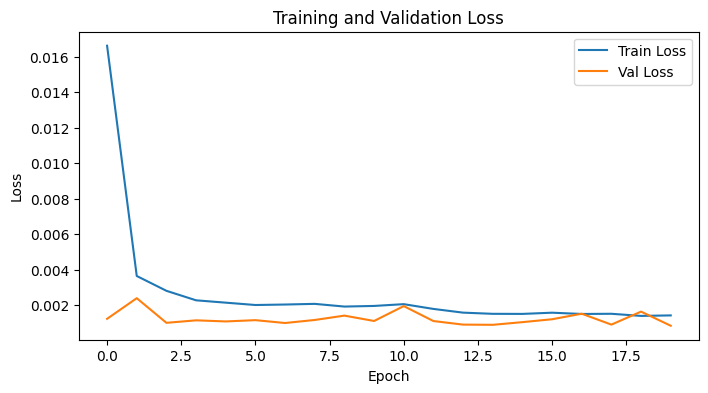

In [13]:
## 4. Plot Training and Validation Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [14]:
## 5. Predict and Inverse Transform
predicted = model.predict(x_test)
# Inverse transform
predicted_prices = scaler.inverse_transform(np.concatenate([np.zeros((predicted.shape[0], data.shape[1]-1)), predicted], axis=1))[:, -1]
actual_prices = scaler.inverse_transform(np.concatenate([np.zeros((y_test.shape[0], data.shape[1]-1)), y_test.reshape(-1,1)], axis=1))[:, -1]

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


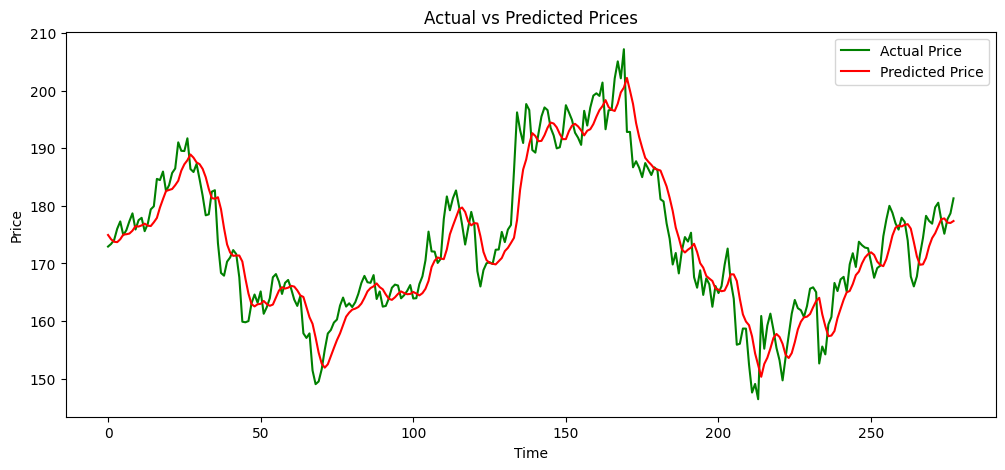

In [15]:
## 6. Plot Actual vs Predicted Prices
plt.figure(figsize=(12,5))
plt.plot(actual_prices, label='Actual Price', color='g')
plt.plot(predicted_prices, label='Predicted Price', color='r')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [16]:
## 7. Calculate Accuracy Metrics
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R² Score: {r2:.2f}')

RMSE: 4.51
MAE: 3.52
R² Score: 0.87


In [17]:
model.save('Stock_GRU_Model.keras')
print('Model saved as Stock_GRU_Model.keras')

Model saved as Stock_GRU_Model.keras
